In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import win32com.client as win32
# import sqlite3 as sql
# from scipy.optimize import minimize
# from scipy.optimize import fsolve
import time

In [2]:
aspen=win32.Dispatch('Apwn.Document')
direccion="C:\\Users\\ASUS\\Documents\\Universidad\\Tesis\\Convergencia_Newton\\Simulación\\equation_oriented.apw"

aspen.InitFromArchive2(direccion)
# La siguiente linea determina si el ASPEN es visible o no
aspen.visible=False
print(f"Aspen cargado")
def correr_simulacion(aspen):
    aspen.Engine.Run2()
    while aspen.Engine.isRunning:
        #Esta linea solo hace una espera cuando se corre la simulación, evitando que se corra dos veces en simultaneo
        time.sleep(1)



Aspen cargado


In [3]:
def error(x1,x2):
    return (x1-x2)/x1
def calculo_error(x,args=aspen):
    aspen=args
    # Se realiza un analisis solo para dos variables, el flujo y una concentración
    # Se considera que la concentración de etanol se aproxima a 0, por lo que habria solo dos componentes en la mezcla
    flujo,x1=x
    x2=1-x1
    if x1>=1:
        x1=1
        x2=0
    # bloques=aspen.Tree.Elements.Item('Data').Elements.Item('Blocks')
    corrientes=aspen.Tree.Elements.Item('Data').Elements.Item('Streams')
    corriente_ingreso=corrientes.Elements.Item('GLR+').Elements.Item("Input")
    Flujo_ingreso=corriente_ingreso.Elements.Item("TOTFLOW").Elements.Item("MIXED")
    Flujo_ingreso.Value=flujo
    concentracion_ingreso=corriente_ingreso.Elements.Item("FLOW").Elements.Item("MIXED")
        
    concentracion_ingreso.Elements.Item("GLYCE-01").Value=x1
    concentracion_ingreso.Elements.Item("WATER").Value=x2
    # concentracion_ingreso.Elements.Item("ETHAN-01").Value=x3
    
    correr_simulacion(aspen)
    
    corriente_salida=corrientes.Elements.Item('GLR').Elements.Item("Output")
    flujo_salida=corriente_salida.Elements.Item("TOT_FLOW").Value
    concentracion_salida=corriente_salida.Elements.Item("MOLEFRAC").Elements.Item("MIXED")
    salida_glicerina=concentracion_salida.Elements.Item("GLYCE-01").Value
    salida_agua=concentracion_salida.Elements.Item("WATER").Value
    salida_etanol=concentracion_salida.Elements.Item("ETHAN-01").Value
    error_glicerina=error(salida_glicerina,x1)
    # error_agua=error(salida_agua,1-x1)
    error_flujo=error(flujo_salida,flujo)
    # print(f"el flujo supuesto es {flujo} y el flujo real es {flujo_salida}")
    # error_etanol=error(salida_etanol,1-x1-x2)
    return [error_flujo,error_glicerina]
    # norma=np.linalg.norm([error_glicerina,error_agua,error_flujo,error_etanol])
    # return norma
    
    

In [4]:
def jacobiano(variables,ASPEN):
    # Estas son las variables que se van a modificar, en este caso el flujo y la concentración
    flujo,x1=variables
    #se establece un delta de las variables del 1% de su valor
    delta=0.01
    
    flujo_1=flujo+delta*flujo
    flujo_2=flujo-delta*flujo
    
    x1_1=x1+delta*x1
    x1_2=x1-delta*x1
    
    Ds=ASPEN.Tree.Elements.Item("Data").Elements.Item("Flowsheeting Options").Elements.Item("Design-Spec")
    Limite_Flujo=Ds.Elements.Item("DS-1").Elements.Item("Input").Elements.Item("EXPR2").Value
    Limite_Flujo=int(Limite_Flujo)
    if x1_1>=1:
        x1_1=1
        x1_2=1-2*delta
    if flujo_1>=Limite_Flujo:
        flujo_1=Limite_Flujo
        flujo_2=Limite_Flujo-2*delta
    delta_flujo=flujo_1-flujo_2
    delta_x1=x1_1-x1_2
    J=np.zeros((2,2))
    J[0,0]=(calculo_error([flujo_1,x1],ASPEN)[0]-calculo_error([flujo_2,x1],ASPEN)[0] )/delta_flujo
    J[0,1]=(calculo_error([flujo,x1_1],ASPEN)[0]-calculo_error([flujo,x1_2],ASPEN)[0] )/delta_x1
    J[1,0]=(calculo_error([flujo_1,x1],ASPEN)[1]-calculo_error([flujo_2,x1],ASPEN)[1] )/delta_flujo
    J[1,1]=(calculo_error([flujo,x1_1],ASPEN)[1]-calculo_error([flujo,x1_2],ASPEN)[1] )/delta_x1
    return J
    

In [5]:
def newton_raphson(fun,variables,ASPEN=aspen,iteraciones_maximas=10):
    tol=1e-6
    error=1
    iteracion=0
    memoria=np.zeros((0,2))
    memoria=np.append(memoria,[variables],axis=0)
    errores=np.zeros((0,2))
    DS=ASPEN.Tree.Elements.Item("Data").Elements.Item("Flowsheeting Options").Elements.Item("Design-Spec")
    Limite_Flujo=DS.Elements.Item("DS-1").Elements.Item("Input").Elements.Item("EXPR2").Value
    Limite_Flujo=int(Limite_Flujo)
    while error>tol and iteracion<iteraciones_maximas:
        if variables[0]>=Limite_Flujo:
            variables[0]=Limite_Flujo
        J=jacobiano(variables,ASPEN)
        # print(J)
        F=np.array(fun(variables,ASPEN))
        # print(F)
        invJ=np.linalg.inv(-J)
        delta=invJ.dot(F)
        # delta=np.linalg.solve(J,-F)
        variables=variables+delta
        error=np.linalg.norm(F)
        memoria=np.append(memoria,[variables],axis=0)
        errores=np.append(errores,[F],axis=0)
        iteracion+=1
    if iteracion==iteraciones_maximas:
        print("No se encontró la solución")
        print(f"El error fue de {error}")
    return variables
    # return variables,memoria,iteracion,errores

In [6]:
# x=[109,0.999]
# print(calculo_error(x))
# resultado=newton_raphson(calculo_error,x)
# print(resultado)


In [7]:
def derivada_reflujo(reflujo,variables,aspen):
    #Esta función evalua la derivada de nuestra función objetivo con respecto al reflujo de la primera columna
    #Se establece un reflujo del 1%
    delta=0.01
    
    reflujo_1=reflujo*(1+delta)
    reflujo_2=reflujo*(1-delta)
    
    bloques=aspen.Tree.Elements.Item('Data').Elements.Item('Blocks')
    columna_1=bloques.Elements.Item("C1").Elements.Item("Input")
    reflujo_aspen=columna_1.Elements.Item("BASIS_RR")
    
    reflujo_aspen.Value=reflujo_1
    punto_1=calculo_error(variables,aspen)
    
    reflujo_aspen.Value=reflujo_2
    punto_2=calculo_error(variables,aspen)
    
    resultado=[(punto_1[0]-punto_2[0])/(2*delta*reflujo),(punto_1[1]-punto_2[1])/(2*delta*reflujo)]
    resultado=np.array(resultado)
    return resultado

In [8]:
# x=[96,0.9997]
# reflujo=0.51
# derivada_reflujo(reflujo,x,aspen)

In [9]:
def Metodo_Continuacion(puntos_iniciales,Aspen,intervalo_reflujo, puntos=10):
    #Se genera un vector de los puntos de reflujo que se van a evaluar
    vector_reflujo=np.linspace(intervalo_reflujo[0],intervalo_reflujo[1],puntos)
    
    bloques=Aspen.Tree.Elements.Item('Data').Elements.Item('Blocks')
    corrientes=Aspen.Tree.Elements.Item("Data").Elements.Item("Streams")
    
    corriente_ethanol=corrientes.Elements.Item("E").Elements.Item("Output")
    corriente_agua=corrientes.Elements.Item("W").Elements.Item("Output")
    corriente_Glicerina_Fresca=corrientes.Elements.Item("GLF").Elements.Item("Output")
    concentracion_ethanol=corriente_ethanol.Elements.Item("MOLEFRAC").Elements.Item("MIXED").Elements.Item("ETHAN-01")
    concentracion_agua=corriente_agua.Elements.Item("MOLEFRAC").Elements.Item("MIXED").Elements.Item("WATER")
    flujo_glicerina_fresca=corriente_Glicerina_Fresca.Elements.Item("TOT_FLOW")
    
    columna_1=bloques.Elements.Item("C1").Elements.Item("Input")
    reflujo_aspen=columna_1.Elements.Item("BASIS_RR")
    
    reflujo_aspen.Value=vector_reflujo[0]
    vector_soluciones=np.zeros((0,2))
    vector_supuestos=np.zeros((0,2))
    
    vector_supuestos=np.append(vector_supuestos,[puntos_iniciales],axis=0)
    primera_solucion=newton_raphson(calculo_error,puntos_iniciales,Aspen)
    vector_soluciones=np.append(vector_soluciones,[primera_solucion],axis=0)
    print(primera_solucion)
    variables=[concentracion_ethanol.Value,concentracion_agua.Value,flujo_glicerina_fresca.Value,float(vector_reflujo[0])]
    print(variables)
    Dataframe_resultado=pd.DataFrame(columns=["Etanol","Agua","Flujo","Reflujo"])
    Dataframe_resultado.loc[0]=variables
    # vector_variables=np.append(vector_variables,variables,axis=0)
    for iteracion in range(puntos):
        if iteracion==0:
            continue
        derivada_flujo=derivada_reflujo(vector_reflujo[iteracion-1],vector_soluciones[iteracion-1],Aspen)
        jacobiano_flujo=jacobiano(vector_soluciones[iteracion-1],Aspen)
        delta_reflujo=vector_reflujo[iteracion]-vector_reflujo[iteracion-1]
        delta=np.linalg.inv(-jacobiano_flujo).dot(derivada_flujo)
        delta_x=delta_reflujo*delta
        vector_supuestos=np.append(vector_supuestos,[vector_soluciones[iteracion-1]+delta_x],axis=0)
        solucion_iteracion=newton_raphson(calculo_error,vector_supuestos[iteracion],Aspen)
        print(solucion_iteracion)
        vector_soluciones=np.append(vector_soluciones,[solucion_iteracion],axis=0)
        variables=[concentracion_ethanol.Value,concentracion_agua.Value,flujo_glicerina_fresca.Value,vector_reflujo[iteracion]]
        Dataframe_resultado.loc[iteracion]=variables
        if iteracion%2==0:
            print(f"Se han completado {iteracion} iteraciones")
    return Dataframe_resultado
        
        
    
    

In [12]:
x=[96,0.9997]
intervalo_reflujo=[0.25,2]
puntos=20
resultado=Metodo_Continuacion(x,aspen,intervalo_reflujo,puntos)
print(resultado)


[98.653111    1.00012434]
[0.996336592, 0.912514366, 1.346889, 0.25]
[98.653111   1.0001236]
[98.653111    1.00012289]
Se han completado 2 iteraciones
[98.653111    1.00012219]
[98.653111    1.00012148]
Se han completado 4 iteraciones
[98.653111    1.00012079]
[98.653111    1.00012011]
Se han completado 6 iteraciones
[98.653111    1.00011942]
[98.653111    1.00011875]
Se han completado 8 iteraciones
[98.653111    1.00011808]
[98.653111    1.00011743]
Se han completado 10 iteraciones
[98.653111   1.0001168]
[98.653111    1.00011617]
Se han completado 12 iteraciones
[98.653111    1.00011555]
[98.653111    1.00011495]
Se han completado 14 iteraciones
[98.653111    1.00011436]
[98.653111    1.00011378]
Se han completado 16 iteraciones
[98.653111    1.00011322]
[98.653111    1.00011266]
Se han completado 18 iteraciones
[98.653111    1.00011211]
      Etanol      Agua     Flujo   Reflujo
0   0.996337  0.912514  1.346889  0.250000
1   0.996178  0.911427  1.346889  0.342105
2   0.998826  0.929

In [13]:
# aspen.Close()
aspen.Quit()

In [14]:
print(resultado)

      Etanol      Agua     Flujo   Reflujo
0   0.996337  0.912514  1.346889  0.250000
1   0.996178  0.911427  1.346889  0.342105
2   0.998826  0.929580  1.346889  0.434211
3   0.999280  0.932689  1.346889  0.526316
4   0.999392  0.933455  1.346889  0.618421
5   0.999402  0.933524  1.346889  0.710526
6   0.999364  0.933266  1.346889  0.802632
7   0.999296  0.932801  1.346889  0.894737
8   0.999205  0.932173  1.346889  0.986842
9   0.999093  0.931405  1.346889  1.078947
10  0.998962  0.930508  1.346889  1.171053
11  0.998813  0.929489  1.346889  1.263158
12  0.998647  0.928354  1.346889  1.355263
13  0.998466  0.927107  1.346889  1.447368
14  0.998268  0.925754  1.346889  1.539474
15  0.998056  0.924298  1.346889  1.631579
16  0.997829  0.922745  1.346889  1.723684
17  0.997589  0.921098  1.346889  1.815789
18  0.997336  0.919364  1.346889  1.907895
19  0.997071  0.917546  1.346889  2.000000


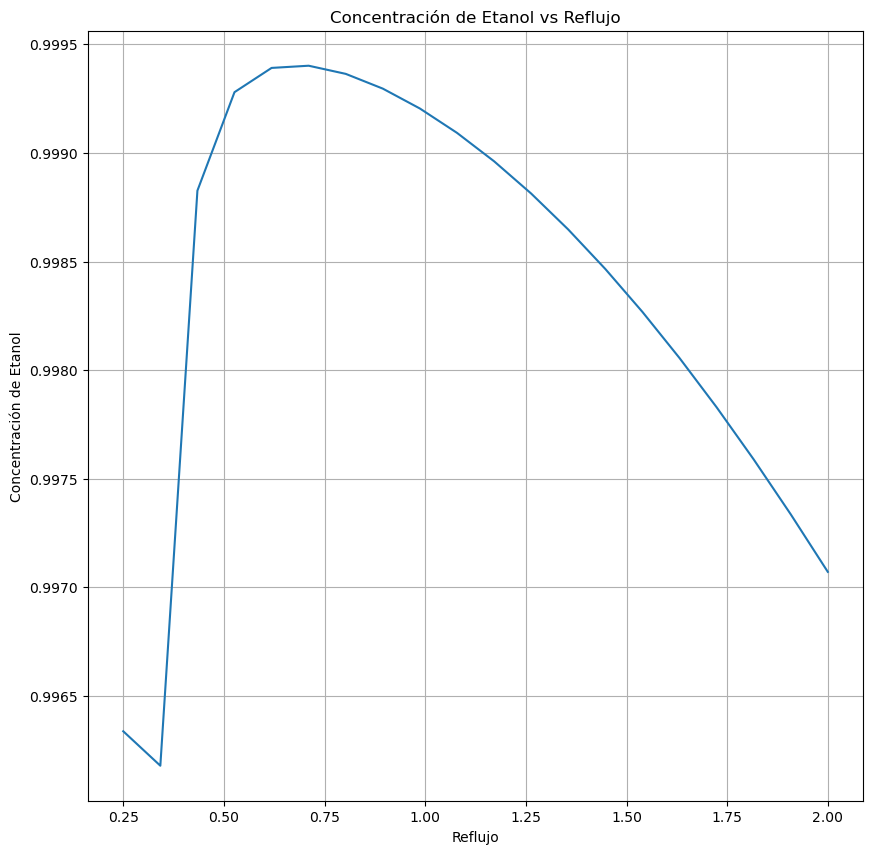

In [16]:
plt.figure(figsize=(10,10))

plt.plot(resultado["Reflujo"],resultado["Etanol"])
plt.xlabel("Reflujo")
plt.ylabel("Concentración de Etanol")
plt.title("Concentración de Etanol vs Reflujo")
plt.grid()

plt.show()

In [52]:
# resultado.to_excel("Resultados_Newton.xlsx")

In [26]:
dir_datos_aspen="C:\\Users\\ASUS\\Documents\\Universidad\\Tesis\\Informes parciales\\Informe_3\\Resultados.xlsx"
datos_aspen=pd.read_excel(dir_datos_aspen,sheet_name="DESC")
print(datos_aspen)

      Reflujo    etanol  FETH KMOL/HR     EGY1 KW     EGY2 KW   ENERGY KW  \
0    0.250000  0.996337    218.543417  3761.99897  624.305816  4386.30478   
1    0.258794  0.996838    218.653362  3790.55472  617.152881  4407.70760   
2    0.267588  0.997257    218.745222  3818.12280  611.001517  4429.12431   
3    0.276382  0.997603    218.821221  3844.76726  605.785417  4450.55268   
4    0.285176  0.997889    218.883800  3870.59066  601.401392  4471.99205   
..        ...       ...           ...         ...         ...         ...   
195  1.964824  0.996840    218.653796  7960.39405  617.131812  8577.52586   
196  1.973618  0.996813    218.647855  7981.50506  617.524124  8599.02919   
197  1.982412  0.996786    218.641892  8002.61537  617.917202  8620.53258   
198  1.991206  0.996759    218.635908  8023.72559  618.310970  8642.03656   
199  2.000000  0.996733    218.630241  8044.94238  618.676278  8663.61866   

     WATER KMOL/HR  FGLY KMOL/HR    XWATER    GLYCOL   GLYCOL2  
0         

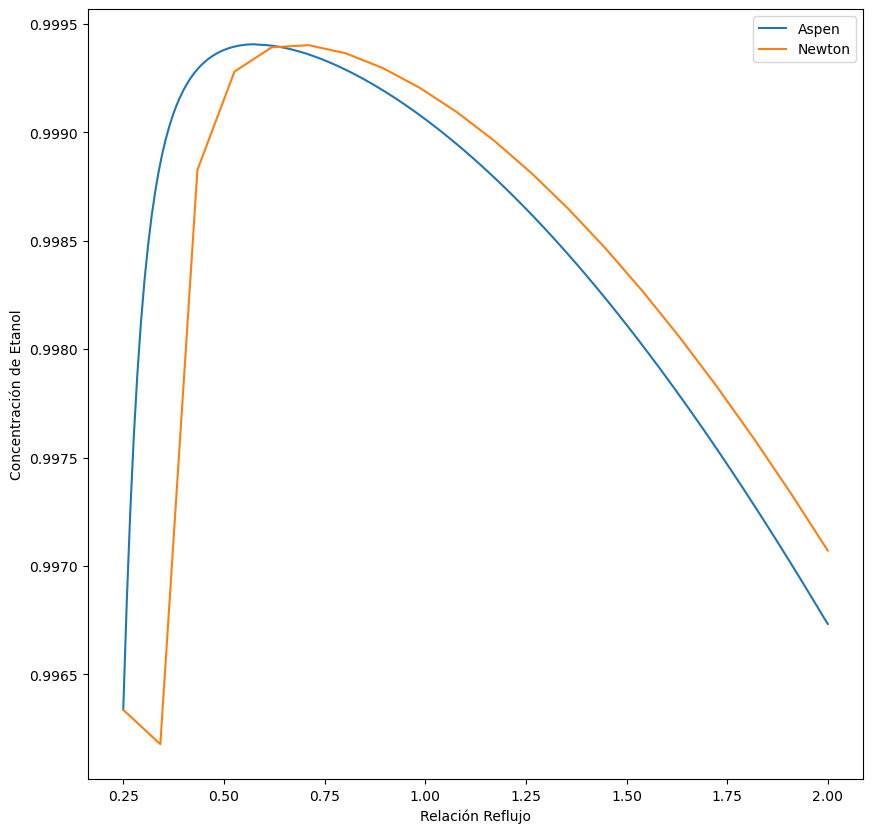

In [30]:
plt.figure(figsize=(10,10))
plt.plot(datos_aspen["Reflujo"],datos_aspen["etanol"],label="Aspen")
plt.plot(resultado["Reflujo"],resultado["Etanol"],label="Newton")
plt.legend()
plt.xlabel("Relación Reflujo")
plt.ylabel("Concentración de Etanol")
plt.show()